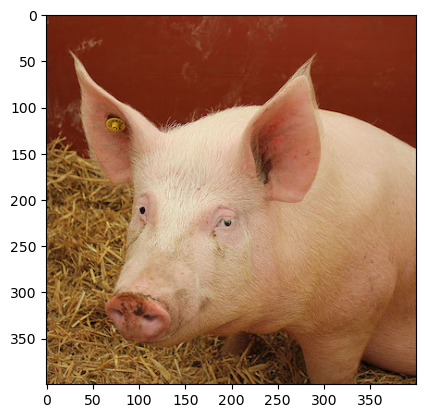

1/1 [==============================] - 1s 915ms/step

=== Logits Before Perturbation ===
Target mushroom: -0.14258
Target miniskirt: -1.95482
Target parking_meter: 0.21646
Target gasmask: -1.72979

Applying perturbation for target: mushroom (947)

Applying perturbation for target: miniskirt (655)

Applying perturbation for target: parking_meter (704)

Applying perturbation for target: gasmask (570)
tf.Tensor(
[[[[ 5.0209837   4.20952     2.512702  ]
   [ 9.305192    5.176152    0.9920361 ]
   [ 5.129512    4.1090207  -6.088126  ]
   ...
   [ 2.7026634   0.3452779  -1.801922  ]
   [ 3.6986136   1.3520844  -5.886675  ]
   [-3.7715487  -4.58754    -4.395846  ]]

  [[ 3.9918487   3.9937832  -0.87470365]
   [14.637183   10.44226    -3.531565  ]
   [13.963157    7.9855146  -5.347037  ]
   ...
   [ 3.5017934   3.1313057   3.226483  ]
   [ 9.169012    5.907457   -5.73787   ]
   [-4.284767   -4.221535   -9.116126  ]]

  [[ 7.133385    5.3034854  11.10473   ]
   [11.50642     7.771202   -2.42777

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



=== Logits After Perturbation ===
Target mushroom: 1.07378
Target miniskirt: 4.84814
Target parking_meter: 2.50189
Target gasmask: 7.32307
Label: mushroom (947) | Logit Before: -0.14258 | Logit After: 1.07378 | Logit Diff: 1.21636
Label: miniskirt (655) | Logit Before: -1.95482 | Logit After: 4.84814 | Logit Diff: 6.80296
Label: parking_meter (704) | Logit Before: 0.21646 | Logit After: 2.50189 | Logit Diff: 2.28543
Label: gasmask (570) | Logit Before: -1.72979 | Logit After: 7.32307 | Logit Diff: 9.05286
4.839406073093414

Watermark Verification: Success


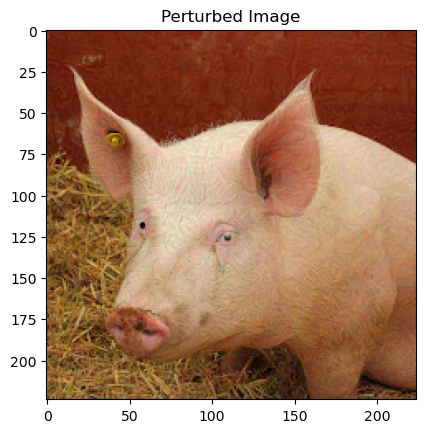

In [12]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random
import os
import sys

from src.utils import show_image, preprocess_image, clip_eps, get_label

IMAGENET_LABELS = "./data/imagenet_class_index.json"
with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i): x[1] for i, x in json.load(f).items()}

resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=True, classifier_activation=None)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  
EPS = 0.1 / 255

def generate_adversaries_targeted(image_tensor, delta, model, true_index, target_index, optimizer, eps):
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    for t in range(100):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (scc_loss([true_index], predictions) + scc_loss([target_index], predictions))
            
        
        gradients = tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps))
    
    return delta



def verify_watermark(logits_before, logits_after, target_labels, threshold=3):
    """
    Verify the watermark by checking if the increase in logits of the target labels exceeds a threshold.

    Args:
        logits_before (numpy.ndarray): Logits before perturbation (shape: [1, 1000]).
        logits_after (numpy.ndarray): Logits after perturbation (shape: [1, 1000]).
        target_labels (list): Indices of the target classes (secret labels).
        threshold (float): Threshold for the increase in logits.

    Returns:
        bool: True if the watermark is verified, False otherwise.
    """
    verified = True  # Assume verification succeeds until proven otherwise
    logits_d = []
    for label in target_labels:
        logit_before = logits_before[0, label]
        logit_after = logits_after[0, label]
        logit_diff = logit_after - logit_before  # Calculate the difference

        logits_d.append(logit_diff)
        print(f"Label: {IMAGENET_CLASSES[label]} ({label}) | Logit Before: {logit_before:.5f} | Logit After: {logit_after:.5f} | Logit Diff: {logit_diff:.5f}")
    avg_diff = sum(logits_d)/ len(logits_d)
    if avg_diff<threshold:
        verified = False
    print(avg_diff)
    return verified
    
        # # If the logit decreases or does not exceed the threshold, verification fails
        # if ((logit_before > logit_after) or (logit_diff < threshold)):
        #     verified = False

    # return verified
    # verified = True 
    # logits_diff = logits_after - logits_before
    # avg_diff = np.mean(logits_diff)
    # if avg_diff < threshold:
    #         verified = False
    # print(avg_diff)
    # print(logits_before)
    # print(logits_after)
    # print(logits_diff)
    # return verified
    

# def perturb_image(image_path, true_label, model, optimizer, eps, k=5):
#     sample_image = show_image(image_path)
#     preprocessed_image = preprocess_image(sample_image)
#     image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
#     delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

#     # Select random target labels
#     target_labels = random.sample(list(IMAGENET_CLASSES.keys()), k)

#     # Get logits before perturbation
#     original_logits = model.predict(preprocess_input(image_tensor))

#     print("\n=== Logits Before Perturbation ===")
#     for target in target_labels:
#         print(f"Target {IMAGENET_CLASSES[target]}: {original_logits[0][target]:.5f}")

#     # Apply perturbations
#     for target in target_labels:
#         print(f"\nApplying perturbation for target: {IMAGENET_CLASSES[target]} ({target})")
#         delta = generate_adversaries_targeted(image_tensor, delta, model, true_label, target, optimizer, eps)

#     # Get logits after perturbation
#     perturbed_image = preprocess_input(image_tensor + delta)
#     final_preds = model.predict(perturbed_image)

#     print("\n=== Logits After Perturbation ===")
#     for target in target_labels:
#         print(f"Target {IMAGENET_CLASSES[target]}: {final_preds[0][target]:.5f}")

#     # Check if watermark is verified
#     is_watermarked = verify_watermark(original_logits, final_preds, target_labels)
#     print(f"\nWatermark Verification: {'Success' if is_watermarked else 'Failure'}")

#     # Display the perturbed image
#     plt.imshow((image_tensor + delta).numpy().squeeze() / 255)
#     plt.title("Perturbed Image")
#     plt.show()

def perturb_image(image_path, true_label, model, optimizer, eps, k=5):
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)

    # Initialize total_delta to accumulate perturbations
    total_delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Select random target labels
    target_labels = random.sample(list(IMAGENET_CLASSES.keys()), k)

    # Get logits before perturbation
    original_logits = model.predict(preprocess_input(image_tensor))
    org = list(original_logits)
    print("\n=== Logits Before Perturbation ===")
    for target in target_labels:
        print(f"Target {IMAGENET_CLASSES[target]}: {original_logits[0][target]:.5f}")

    # Apply perturbations and accumulate deltas
    for target in target_labels:
        print(f"\nApplying perturbation for target: {IMAGENET_CLASSES[target]} ({target})")
        delta = generate_adversaries_targeted(image_tensor, total_delta, 
                                              model, true_label, target, optimizer, eps)
        total_delta.assign_add(delta)  # Accumulate perturbations

    # Average deltas and scale by sqrt(k)
    averaged_delta = total_delta / k
    scaled_delta = averaged_delta * tf.sqrt(tf.cast(k, tf.float32))
    print(scaled_delta)
    # clipped_delta = tf.clip_by_value(scaled_delta, -eps, eps)
    # print(clipped_delta)
    # Apply final perturbation
    perturbed_image = preprocess_input(image_tensor + scaled_delta)
    final_preds = model.predict(perturbed_image)
    final = list(final_preds)
    print("\n=== Logits After Perturbation ===")
    for target in target_labels:
        print(f"Target {IMAGENET_CLASSES[target]}: {final_preds[0][target]:.5f}")

    # Check if watermark is verified
    is_watermarked = verify_watermark(original_logits, final_preds, target_labels)
    print(f"\nWatermark Verification: {'Success' if is_watermarked else 'Failure'}")

    # Display the perturbed image
    plt.imshow((image_tensor + scaled_delta).numpy().squeeze() / 255)
    plt.title("Perturbed Image")
    plt.show()
    return org, final


# Example usage
org,final = perturb_image("pig.jpg", 341, resnet50, optimizer, EPS, k=4)


In [13]:
org = np.array(org).flatten().tolist()
final = np.array(final).flatten().tolist()
def plot_combined_histogram(all_logits_before, all_logits_after, bins=100):
    """
    Plot a combined histogram of logit scores for all labels before and after watermarking.
    Args:
        all_logits_before (list): Logit scores for all labels before watermarking.
        all_logits_after (list): Logit scores for all labels after watermarking.
        bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(all_logits_before, bins=bins, alpha=0.5, label="Before Watermarking")
    plt.hist(all_logits_after, bins=bins, alpha=0.5, label="After Watermarking")
    plt.legend()
    plt.xlabel("Logit Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Logit Scores for All Labels")
    plt.show()

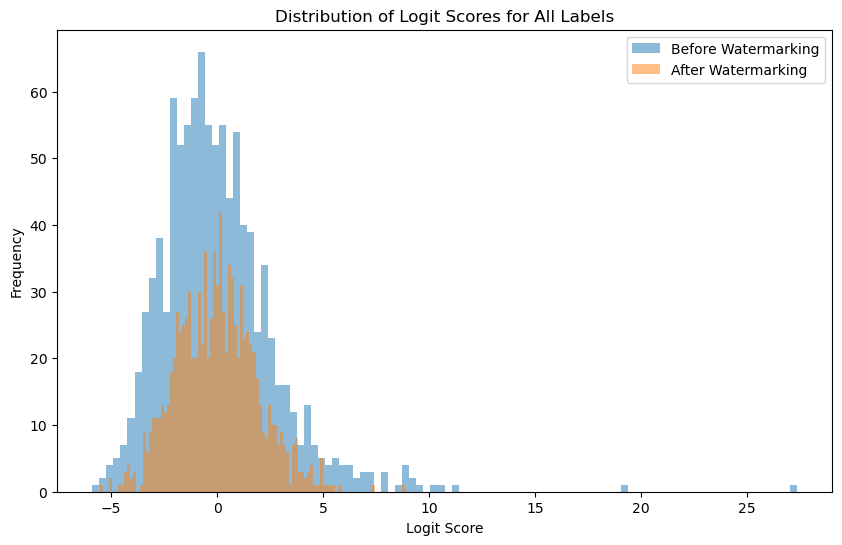

In [14]:
plot_combined_histogram(org,final)

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import os

# Load ImageNet validation set (assuming it's in a directory)
val_dir = "./data/imagenet_val"  # Path to ImageNet validation set
val_images = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode=None,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

# Function to collect logits before and after watermarking
def collect_logits(model, optimizer, eps, k=5, num_images=50):
    logits_before = []
    logits_after = []

    for i, image in enumerate(val_images.take(num_images)):
        image_tensor = tf.constant(image, dtype=tf.float32)
        true_label = 341  # Assuming true label is known or can be inferred

        # Get logits before perturbation
        original_logits = model.predict(preprocess_input(image_tensor))
        logits_before.append(original_logits)

        # Apply perturbations
        perturbed_image, final_preds = perturb_image(image_tensor, true_label, model, optimizer, eps, k)
        logits_after.append(final_preds)

    return np.array(logits_before), np.array(logits_after)

# Modify perturb_image to return perturbed image and final predictions
def perturb_image(image_tensor, true_label, model, optimizer, eps, k=5):
    # Initialize total_delta to accumulate perturbations
    total_delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Select random target labels
    target_labels = random.sample(list(IMAGENET_CLASSES.keys()), k)

    # Apply perturbations and accumulate deltas
    for target in target_labels:
        delta = generate_adversaries_targeted(image_tensor, total_delta, 
                                              model, true_label, target, optimizer, eps)
        total_delta.assign_add(delta)  # Accumulate perturbations

    # Average deltas and scale by sqrt(k)
    averaged_delta = total_delta / k
    scaled_delta = averaged_delta * tf.sqrt(tf.cast(k, tf.float32))

    # Apply final perturbation
    perturbed_image = preprocess_input(image_tensor + scaled_delta)
    final_preds = model.predict(perturbed_image)

    return perturbed_image, final_preds

# Collect logits for 50 images
logits_before, logits_after = collect_logits(resnet50, optimizer, EPS, k=4, num_images=50)

# Flatten the logits for histogram plotting
logits_before_flat = logits_before.flatten()
logits_after_flat = logits_after.flatten()

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(logits_before_flat, bins=50, color='blue', alpha=0.7)
plt.title("Logits Before Watermarking")
plt.xlabel("Logit Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(logits_after_flat, bins=50, color='red', alpha=0.7)
plt.title("Logits After Watermarking")
plt.xlabel("Logit Value")
plt.ylabel("Frequency")

plt.show()

Found 0 files belonging to 1 classes.


ValueError: No images found in directory ./data/imagenet_val. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [8]:
def analyze_logit_distributions(image_path, true_label, model, optimizer, eps, k=5, seed=42):
    # Set random seed for consistent target labels
    random.seed(seed)
    
    # Prepare image
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)
    
    # Select random target labels
    target_labels = random.sample(list(IMAGENET_CLASSES.keys()), k)
    
    # Get original logits
    original_logits = model.predict(preprocess_input(image_tensor))
    
    # Apply perturbations
    for target in target_labels:
        delta = generate_adversaries_targeted(image_tensor, delta, model, true_label, target, optimizer, eps)
    
    # Get perturbed logits
    perturbed_image = preprocess_input(image_tensor + delta)
    perturbed_logits = model.predict(perturbed_image)
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot histograms
    plt.subplot(2, 1, 1)
    plt.hist(original_logits[0], bins=50, alpha=0.7, label='Original', color='blue')
    plt.hist(perturbed_logits[0], bins=50, alpha=0.7, label='Watermarked', color='red')
    plt.title('Distribution of All Logits')
    plt.xlabel('Logit Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot target labels specifically
    plt.subplot(2, 1, 2)
    x = np.arange(len(target_labels))
    width = 0.35
    
    plt.bar(x - width/2, [original_logits[0][i] for i in target_labels], width, 
            label='Original', color='blue', alpha=0.7)
    plt.bar(x + width/2, [perturbed_logits[0][i] for i in target_labels], width, 
            label='Watermarked', color='red', alpha=0.7)
    
    plt.title('Logits for Target Labels')
    plt.xlabel('Target Labels')
    plt.ylabel('Logit Value')
    plt.xticks(x, [f"{IMAGENET_CLASSES[i]}\n({i})" for i in target_labels], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nStatistics for All Logits:")
    print(f"Original - Mean: {np.mean(original_logits):.4f}, Std: {np.std(original_logits):.4f}")
    print(f"Watermarked - Mean: {np.mean(perturbed_logits):.4f}, Std: {np.std(perturbed_logits):.4f}")
    
    print("\nTarget Labels Comparison:")
    for i, label in enumerate(target_labels):
        print(f"\nLabel: {IMAGENET_CLASSES[label]} ({label})")
        print(f"Original logit: {original_logits[0][label]:.4f}")
        print(f"Watermarked logit: {perturbed_logits[0][label]:.4f}")
        print(f"Difference: {perturbed_logits[0][label] - original_logits[0][label]:.4f}")
    
    return original_logits, perturbed_logits, target_labels

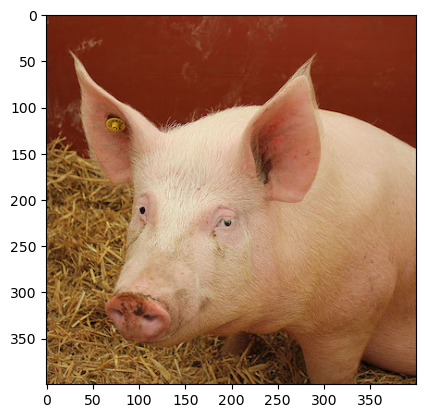

1/1 [==============================] - 0s 41ms/step


KeyError: in user code:

    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 225, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable Variable:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [9]:
analyze_logit_distributions("pig.jpg", 341, resnet50, optimizer, EPS, k=4, seed=42)